In [3]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model

from rbflayer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
import math
import pandas as pd

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years.
The goal is to predict the number of shares in social networks (popularity).<br>
<br>
Reference material <br>
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2799933550853697/3155681567642906/2202577924924539/latest.html<br>
http://benalexkeen.com/feature-scaling-with-scikit-learn/ <br>
https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py <br>
https://archive.ics.uci.edu/ml/datasets/online+news+popularity <br><br>
Target is element 60, shares:     Number of shares
<br>
Omitted url, timedelta, LDA, is_weekend, kw_min_min, kw_avg_min, kw_min_avg<br>
Convert following binary data to categorical data, weekday, data_channel

In [36]:
# loading of dataset 
dataset = []
labels = []
headers = []

def load_dataset_raw():
    global dataset, labels, headers
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        headers = next(reader) # the first row
        headers = headers[1:]
        headers = [x.strip(' ') for x in headers]    
            
        temp_data = []
        temp_label = []
        for idx, row in enumerate(reader):
            temp_data.append(row[1:])
            temp_label.append(row[-1])

        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))   
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def load_dataset(is_normalize=True, is_remove_outlier=True, select_top=50):
    """
    is_normalize: To normalize or keep orignal form
    is_remove_outlier: To remove outlier 
    select_top: select top important features using PCA (Principal component analysis)
    """
    global dataset, labels, headers
    dataset, labels = load_dataset_raw()
    print('Original dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))
    
    fields_to_avoid = [0, 18, 20, 24, 38, 39, 40, 41, 42]
    weekday = [30, 31, 32, 33, 34, 35, 36, 37]
    data_channel = [12, 13, 14, 15, 16, 17]
    fields_to_avoid = fields_to_avoid + weekday + data_channel
    fields_to_avoid = sorted(fields_to_avoid)

    # adjust headers
    sub_headers = []
    for idx, h in enumerate(headers):
        if idx not in fields_to_avoid:
            sub_headers.append(h)
    sub_headers.insert(len(sub_headers) - 1, 'weekday')
    sub_headers.insert(len(sub_headers) - 1, 'data_channel')
    headers = sub_headers
    
    # filter columns and categorical fields
    new_dataset = []        
    for idx, row in enumerate(dataset):
        slice_row = [i for num,i in enumerate(row) if num not in fields_to_avoid]
        insert_idx = len(slice_row) - 1

        for col_idx in range(len(row)):
            # convert week day to categorical 
            if col_idx in weekday and row[col_idx] == 1:
                if col_idx == 30:
                    slice_row.insert(insert_idx, 1)
                elif col_idx == 31:
                    slice_row.insert(insert_idx, 2)
                elif col_idx == 32:
                    slice_row.insert(insert_idx, 3)
                elif col_idx == 33:
                    slice_row.insert(insert_idx, 4)
                elif col_idx == 34:
                    slice_row.insert(insert_idx, 5)
                elif col_idx == 35:
                    slice_row.insert(insert_idx, 6)
                elif col_idx == 36:
                    slice_row.insert(insert_idx, 7)

            # convert data channel to categorical 
            if col_idx in data_channel and row[col_idx] == 1:
                if col_idx == 12:
                    slice_row.insert(insert_idx, 1)
                elif col_idx == 13:
                    slice_row.insert(insert_idx, 2)
                elif col_idx == 14:
                    slice_row.insert(insert_idx, 3)
                elif col_idx == 15:
                    slice_row.insert(insert_idx, 4)
                elif col_idx == 16:
                    slice_row.insert(insert_idx, 5)
                elif col_idx == 17:
                    slice_row.insert(insert_idx, 6)

        # handle missing data
        if len(slice_row) == 38:
            slice_row.append(0)
        new_dataset.append(slice_row)         
    
    # copy filter new_dataset to dataset 
    dataset = new_dataset
    
    # normalizing in dataset
    if is_normalize:
        # it is important which type of normalization method you use
        scaler = preprocessing.MinMaxScaler()
        dataset = scaler.fit_transform(dataset)
        # last item uses MinMaxScaler
        labels = np.array(labels).reshape(-1, 1)
        scaler = preprocessing.QuantileTransformer()
        labels = scaler.fit_transform(labels)
        print('Data is normalize')
    else:
        print('No normalize apply')        

    # remove outlier in dataset
    if is_remove_outlier:
        dataset, labels = reject_outliers(dataset, labels)    

    # applying PCA in dataset
    if 0 < select_top < len(dataset[0]):
        top_features = pca_important_features(dataset, headers, top=select_top)
        feature_keys = [f[1] for f in top_features]
        df = pd.DataFrame(dataset, columns=headers)
        top_dataset = []
        for name in feature_keys:
            top_dataset.append(df.loc[:, name])
        dataset = np.transpose(top_dataset)
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def pca_important_features(dataset, headers, top=10):
    scaleFeatures = True
    pca = PCA(n_components=top)
    projected  = pca.fit_transform(dataset)
    top_features = extract_features(projected, pca.components_, headers, top)
    return top_features
    
def extract_features(transformed_features, components_, columns, top):
    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by top {0} importance:".format(top))
    for feature in important_features[:top]:
        print(feature)
    print()
    return important_features[:top]
        
def reject_outliers(dataset, labels, m=50):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

In [82]:
# Splitting of dataset into train and test
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True, is_remove_outlier=True, select_top=-1)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

# df = pd.DataFrame(np.array(dataset), columns=headers)
# print(dataset[0])
# print(labels[:-10])

Original dataset shape: (39644, 60), Labels: (39644, 1)
Data is normalize
Outlier removed: 0
Dataset shape: (39644, 39), Labels: (39644, 1)
x_train: (31715, 39), y_train: (31715, 1)
x_test: (7929, 39), y_test: (7929, 1)


dataset (39644, 39)
labels (39644, 1)
Labels max value: 0.9999999000000003
Labels min value: 9.999999977795539e-08
Labels avg value: 0.5000743959674698


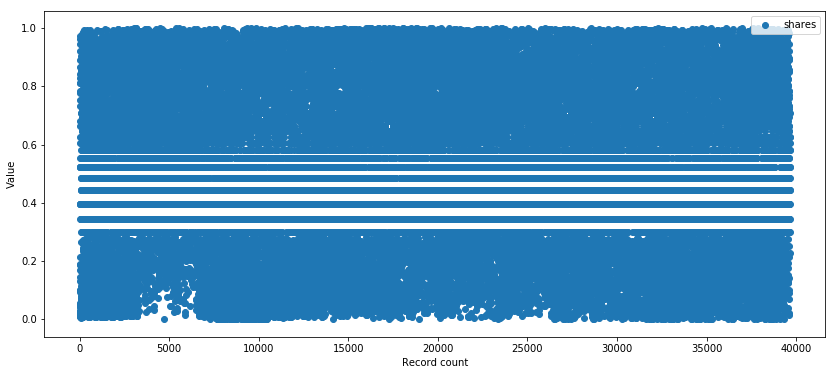

In [83]:
# Quick view of processed datasets
print('dataset {0}'.format(dataset.shape))
print('labels {0}'.format(labels.shape))
print('Labels max value: {0}'.format(np.max(labels)))
print('Labels min value: {0}'.format(np.min(labels)))
print('Labels avg value: {0}'.format(np.average(labels)))

def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Record count")
    plt.ylabel("Value")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

def show_histogram(data):
    plt.figure(figsize=(14,6))
    plt.hist(data, 100)
    plt.show()

show_graph(labels)
# show_histogram(labels)

**Reference**<br>
*kernel_regularizer*: Regularizer function applied to the kernel weights matrix (see regularizer).<br>
*activity_regularizer*: Regularizer function applied to the output of the layer (its "activation").

In [107]:
# https://www.youtube.com/watch?v=1Cw45yNm6VA
# build model
# beta - controls the drop off of circle. higher the beta the faster the circle will drop off. This will then affect the 
#        size of the circle, faster drop off will cause new circle to form.
#        (Drop of refers of gradient of circle, how smooth transit from circle area to non-circle area)
# training with callbacks
l2_kernal = 0.0001

model = Sequential()
model.add(Dense(128, input_shape=(39,), activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
rbflayer = RBFLayer(128,
                    betas=0.5,
                    input_shape=(64,))
model.add(rbflayer)

model.add(Dense(1, activation='tanh'))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 128)               5120      
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
_________________________________________________________________
rbf_layer_68 (RBFLayer)      (None, 128)               8320      
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 129       
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


In [110]:
# training with callbacks
saved_weights_name = 'best_weights_rbf.h5'

if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=6,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=0.00001,
                              verbose=1)
    
history = model.fit(x_train, y_train,
                      epochs=50,
                      validation_data=(x_test, y_test),
                      callbacks=[early_stop, checkpoint, reduce_lr],
                      verbose=1)

Train on 31715 samples, validate on 7929 samples
Epoch 1/50
31715/31715 [==============================] - 15s 479us/step - loss: 0.0564 - mean_squared_error: 0.0468 - val_loss: 0.0759 - val_mean_squared_error: 0.0661

Epoch 00001: val_loss improved from inf to 0.07588, saving model to best_weights_rbf.h5
Epoch 2/50
31715/31715 [==============================] - 16s 500us/step - loss: 0.0565 - mean_squared_error: 0.0468 - val_loss: 0.0774 - val_mean_squared_error: 0.0676

Epoch 00002: val_loss did not improve
Epoch 3/50
31715/31715 [==============================] - 16s 494us/step - loss: 0.0563 - mean_squared_error: 0.0465 - val_loss: 0.0721 - val_mean_squared_error: 0.0622

Epoch 00003: val_loss improved from 0.07588 to 0.07206, saving model to best_weights_rbf.h5
Epoch 4/50
31715/31715 [==============================] - 16s 511us/step - loss: 0.0570 - mean_squared_error: 0.0471 - val_loss: 0.0736 - val_mean_squared_error: 0.0637

Epoch 00004: val_loss did not improve
Epoch 5/50
3171

#### Recall our target is element 45, global_sentiment_polarity: Text sentiment polarity

7929/7929 [==============================] - 1s 131us/step
actual max 0.9992343966165429
actual min 6.387735547748322e-05
actual median 0.4444444444444444
predict max 0.8155842423439026
predict min 0.36368799209594727
predict median 0.48827388882637024

loss: 0.072627
mean_squared_error: 0.071856
root_mse: 0.26806
explained_variance_score: -13.508067
mean_absolute_error: 0.229563
mean_squared_log_error: 0.035154
median_absolute_error: 0.226075
r2_score: -13.675808


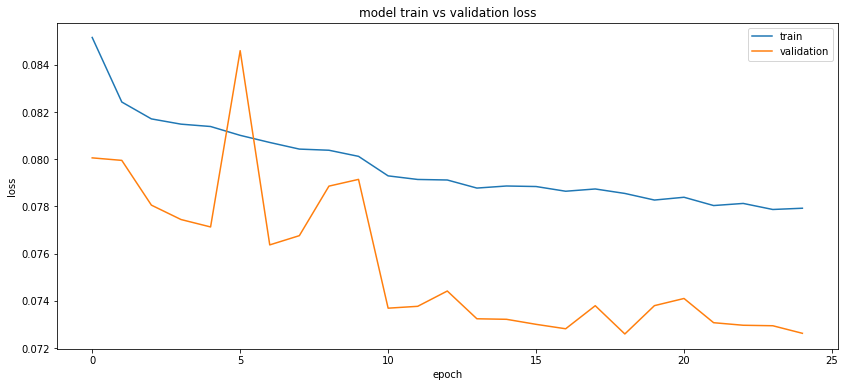

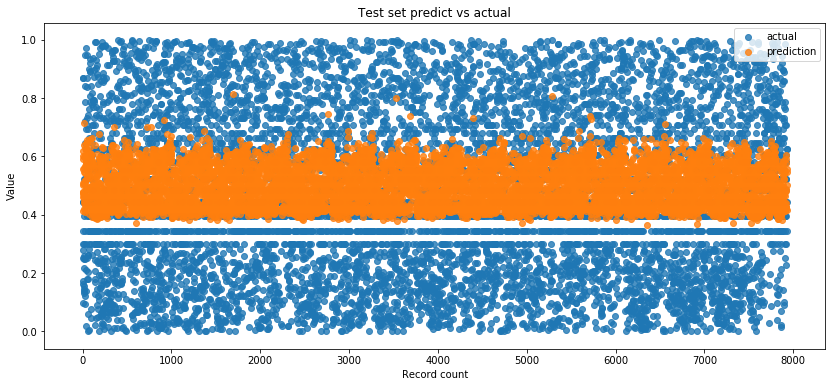

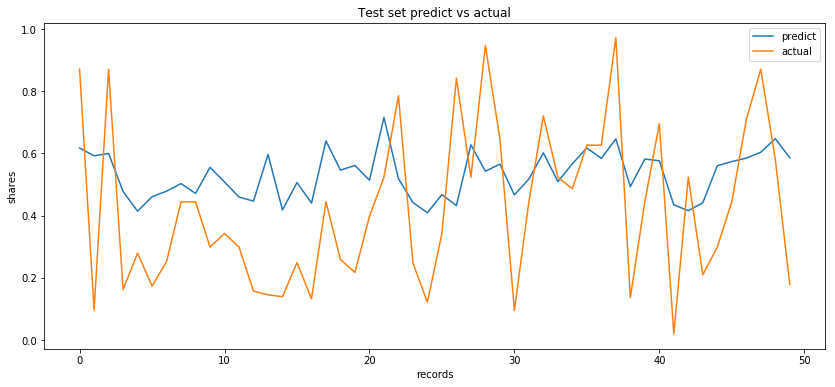

In [104]:
# showing results
scores = model.evaluate(x_test, y_test)

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = model.predict(x_test)

root_mse = math.sqrt(scores[1])
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('actual max {0}'.format(np.max(y_test)))
print('actual min {0}'.format(np.min(y_test)))
print('actual median {0}'.format(np.median(y_test)))
print('predict max {0}'.format(np.max(y_pred)))
print('predict min {0}'.format(np.min(y_pred)))
print('predict median {0}'.format(np.median(y_pred)))
print()
print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
print('root_mse: {0}'.format(round(root_mse, 6)))
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

# plt.figure(figsize=(14,6))
# plt.hist(y_pred, 100)
# plt.hist(y_test, 100)
# plt.show()

plt.figure(figsize=(14,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.xlabel("Record count")
plt.ylabel("Value")
plt.title("Test set predict vs actual")
x = list(range(len(y_pred)))
# plt.ylim(0, 1)
plt.scatter(x, [pt[0] for pt in y_test], label='actual', alpha=0.8)
plt.scatter(x, [pt[0] for pt in y_pred], label='prediction', alpha=0.8)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.title('Test set predict vs actual')
plt.plot(y_pred[:50])
plt.plot(y_test[:50])
plt.ylabel('shares')
plt.xlabel('records')
plt.legend(['predict', 'actual'], loc='upper right', borderaxespad=0.5)
plt.show()

In [ ]:
# kfold on dataset and training
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

kfold_result = []

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for train_index, test_index in kf.split(dataset):
    x_train, x_test = dataset[train_index], dataset[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
#     print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
#     print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))
    
    # build model
    model = Sequential()
    model.add(Dense(128, input_dim=58, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(lr=0.001),
                  metrics=['mse'])
    
    # train model
    early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.00001,
                           patience=10,
                           mode='min',
                           verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  patience=4,
                                  min_lr=0.000001,
                                  verbose=1)

    model.fit(x_train, y_train,
              epochs=50,
              validation_data=(x_test, y_test),
              callbacks=[early_stop, reduce_lr],
              verbose=1)
    
    # evaluating model
    scores = model.evaluate(x_test, y_test)
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    y_pred = model.predict(x_test)
    r2 = r2_score(y_pred, y_test)
    print('r2_score: {0}'.format(round(r2, 6)))
    kfold_result.append([scores[0], scores[1], r2])

In [ ]:
avg_loss = 0
avg_mse = 0
avg_r2 = 0

for idx, scores in enumerate(kfold_result):
    avg_loss += scores[0]
    avg_mse += scores[1]
    avg_r2 += scores[2]
    print('kfold {0}'.format(idx+1))
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    print('r2_score: {0}'.format(round(scores[2], 6)))
    print()

print('kfold average loss: {0}'.format(round(avg_loss, 6)))
print('kfold average mse: {0}'.format(round(avg_mse, 6)))
print('kfold average r2: {0}'.format(round((avg_r2/5), 6)))